In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib 
%matplotlib inline 

In [22]:
class Linear():#(dim2*dim1)*(dim1*1)+(dim2*1)
    def __init__(self, input_dim, output_dim):
        self.shape = (input_dim,output_dim)
        self.weight = np.random.normal(loc = 0, scale = 1, size = (output_dim, input_dim))
        self.bias = np.zeros((output_dim,1))

    def forward(self, input):
        #input = input.transpose()
        #print("shape of input", np.shape(input))
        res = np.matmul(self.weight, input) 
        #print("shape of output", np.shape(res))
        res = res + self.bias
        #print("shape of output", np.shape(res))
        return res
        


In [23]:
class BP():
    def __init__(self, input_dim, output_dim, dataset, layernum = 4, learning_rate = 0.5):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dataset = dataset
        self.layernum = layernum
        self.learning_rate = learning_rate
        """self.layers[0] = Linear(input_dim, 16)
        self.layers[1] = Linear(16, 16)
        self.layers[2] = Linear(16, 8)
        self.layers[3] = Linear(8,output_dim)
        """
        self.layers = (Linear(input_dim, 16), Linear(16, 16), Linear(16, 8), Linear(8, output_dim))
        self.checkpoint = [1,2,3,4,5,6]
        #np.random.shuffle(self.dataset)
        self.validationset, self.trainset = np.split(self.dataset,[int(self.dataset.shape[0]/3)],axis = 0)

    def sigmoid(self, input):
        return 1.0/(1+np.exp(-input))

    def softmax(self, input):
        tempexp = np.exp(input)
        return (tempexp)/(np.sum(tempexp, axis = 0))
    
    def test(self):
        """temp = np.ones((5, 1))
        print("temp is ", temp)
        print("sigmoid is ", self.sigmoid(temp))
        print("softmax is ", self.softmax(temp))
        """
        """
        print(np.shape(self.layers[1].weight))
        print(self.layers[1].weight)
        """
        
        #test forward
        testinput = np.random.rand(1,8)
        testoutput = self.forward(testinput)
        #print("input is ", testinput)
        #print("output is ", testoutput)
    
    def forward(self, input):
        output = input.transpose()
        self.checkpoint[0] = output
        for i in range(self.layernum):
            #print("round ",i)
            #print("input is ",output)
            output = self.layers[i].forward(output)
            output = self.sigmoid(output)
            #print("output is ",output)
            self.checkpoint[i+1] = output
            #print(self.checkpoint[i])
        predict = self.softmax(output)
        return predict
    
    def crossentropyloss(self, true, predict):
        a = np.array([0.001,0.001,0.001])
        #print(predict)
        predict = predict + a
        temp = np.log(predict)
        temp = np.multiply(temp, true)#对应元素相乘
        return np.sum(temp, axis = 0)[0]

    def total_loss(self, data):#计算某一个数据集或者某一个batach上总的损失值
        total = 0
        data_x, data_y = np.split(data,[data.shape[1]-1],axis = 1) #分割featrure and label
        for i in range(0, data.shape[0], 1):
            x = data_x[i]
            y = data_y[i]
            #将y的label值转换为one hot vector
            labely = np.zeros((1, self.output_dim))
            labely[0][int(y)] = 1
            total = total + self.crossentropyloss(labely, self.forward(x).transpose())
            #这里数据类型之类的东西要仔细检查一下 
        return total

    def backward(self, true, predict):#这里的缺陷在于不是batch的SGD
        # partial L / partial output
        #print("shape of predict is ", np.shape(predict))
        #print("shape of true label is ", np.shape(true))
        previous_gradient = predict - true
        for i in range(self.layernum - 1, -1, -1):
            #print("round ", i)
            checkpoint = self.checkpoint[i+1]
            #current_gradient = np.matmul(checkpoint, (1 - checkpoint))
            current_gradient = np.multiply(checkpoint, (1 - checkpoint))
            #print("shape of partial sigmoid is ", np.shape(current_gradient))
            #current_gradient = np.matmul(previous_gradient, current_gradient)
            current_gradient = np.multiply(current_gradient, previous_gradient)
            #print("shape of current gradient is", np.shape(current_gradient))
            #gradient_w = np.matmul(current_gradient, self.checkpoint[i-1].transpose())
            gradient_w = np.matmul(current_gradient, self.checkpoint[i].transpose())
            gradient_b = current_gradient#梯度算法需要检查一下
            #previous_gradient = np.matmul(current_gradient, self.layers[i].weight)#先把梯度传下去，然后再更新
            previous_gradient = np.matmul(self.layers[i].weight.transpose(), current_gradient)#先把梯度传下去，然后再更新
            
            self.layers[i].weight = self.layers[i].weight - self.learning_rate * gradient_w
            self.layers[i].bias = self.layers[i].bias - self.learning_rate * gradient_b

    def train(self, batchsize = 5, epoch = 100):
        TrainLoss = np.zeros((epoch))
        ValidationLoss = np.zeros((epoch))
        for i in range(0, epoch, 1):
            np.random.shuffle(self.trainset)
            data_x, data_y = np.split(self.trainset,[self.trainset.shape[1]-1],axis = 1)
            for j in range(0, batchsize, 1):
                x = data_x[j]
                y = data_y[j]
                #print(x)
                #print(y)
                x = np.expand_dims(x, axis=0)
                predict = self.forward(x)
                labely = np.zeros((1, self.output_dim))
                labely[0][int(y)] = 1
                self.backward(labely.transpose(),predict)
            #TrainLoss[i] = self.total_loss(self.trainset)
            ValidationLoss[i] = self.total_loss(self.validationset)
        self.display(TrainLoss, ValidationLoss)

    def display(self, TrainLoss, ValidationLoss):
        epoch = TrainLoss.shape[0]
        epoch = np.arange(epoch)
        plt.figure()
        plt.xlabel("epoch")
        plt.ylabel("loss")
        #plt.plot(epoch, TrainLoss, label = "Train", color = 'r')
        plt.plot(epoch, ValidationLoss, label = "Validation")
        plt.legend()
            




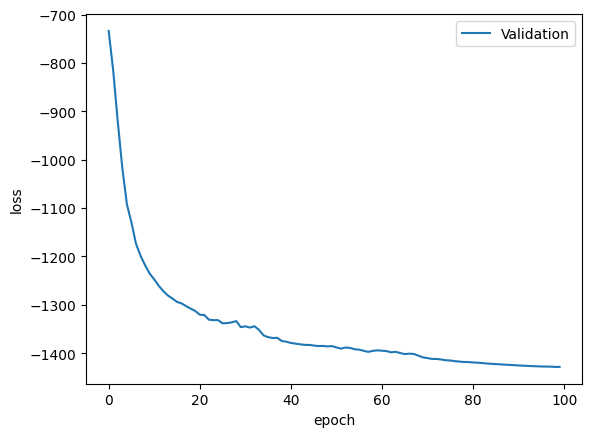

In [24]:
dataset = pd.read_csv('/home/cyberimpart/cyf/ML_by_hand/iris.csv')
dataset = np.array(dataset.values)
tester = BP(4, 3, dataset)
#tester.test()
tester.train()
#labely = np.zeros((1, 3))
#labely[0][2] = 1
#print(labely)
